In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

from scipy import stats
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

In [4]:
import boto3
from io import BytesIO

In [5]:
files=['data/barrell BREAKING.csv','data/barrell FAST.csv','data/barrell OFFSPEED.csv','data/flare:burner BREAKING.csv','data/flare:burner FAST.csv',
       'data/flare:burner OFFSPEED.csv','data/no contact BREAKING.csv','data/no contact FAST.csv','data/no contact OFFSPEED.csv','data/poor:top BREAKING.csv',
      'data/poor:top OFFSPEED.csv','data/poor:top FAST.csv','data/poor:under BREAKING.csv','data/poor:under OFFSPEED.csv','data/poor:under FAST.csv',
      'data/poor:weak BREAKING.csv','data/poor:weak OFFSPEED.csv','data/poor:weak FAST.csv','data/solid contact BREAKING.csv','data/solid contact OFFSPEED.csv','data/solid contact FAST.csv']

In [6]:
def load_pitch_data_from_s3(csv_files, number_of_rows=None, bucket='qualitycontact'):
    '''
    Function to take a list of loan data CSV files that stored in an AWS S3 bucket and load and
    concatenate them into one dataframe.
    Args:
        csv_files (list or tuple): List of CSV files that contain the data. Below is a tuple of the names of the
        available files from Lending Club as of April 2019.
        ('LoanStats3a_securev1.csv', 'LoanStats3b_securev1.csv', 'LoanStats3c_securev1.csv', 'LoanStats3d_securev1.csv',
         'LoanStats_securev1_2016Q1.csv', 'LoanStats_securev1_2016Q2.csv', 'LoanStats_securev1_2016Q3.csv',
         'LoanStats_securev1_2016Q4.csv', 'LoanStats_securev1_2017Q1.csv', 'LoanStats_securev1_2017Q2.csv', 
         'LoanStats_securev1_2017Q3.csv', 'LoanStats_securev1_2017Q4.csv', 'LoanStats_securev1_2018Q1.csv',
         'LoanStats_securev1_2018Q2.csv', 'LoanStats_securev1_2018Q3.csv', 'LoanStats_securev1_2018Q4.csv')
        columns (list or tuple): List of column names that should be used in the dataframe. Certain columns should be
        excluded due to the fact they would not have been available at the time the loan was issued.
        The list of accetable columns is generated by the the file `columns.py` in the src folder and stored in 
        the variable columns_to_use.
        number_of_rows (int or None): The number of rows to load from each CSV file. This is used to load in smaller 
        amounts of data for testing purposes. By default, number_of_rows is None, which loads all data.
        bucket (string): Name of the S3 bucket the files are stored in. My bucket is called 'loan-analysis-data'.
    Returns:
        DataFrame: Returns a dataframe containing all loans contained within the list of CSV files.  
    '''
    datadict={}
    pitch_data = []
    for filename in csv_files:
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket=bucket, Key=filename)
        data = obj['Body'].read()
        f = BytesIO(data)
        data = pd.read_csv(f, low_memory=False, na_values='n/a', nrows=number_of_rows) 
        
        #Creating contact quality column and pitch type column
        datadict[filename]=data
        if filename in ['data/barrell BREAKING.csv','data/barrell FAST.csv','data/barrell OFFSPEED.csv','data/flare:burner BREAKING.csv','data/flare:burner FAST.csv','data/flare:burner OFFSPEED.csv', 'data/solid contact BREAKING.csv','data/solid contact OFFSPEED.csv','data/solid contact FAST.csv']:
            datadict[filename]['contact quality'] = 1
        else:
            datadict[filename]['contact quality'] = 0
            
        if filename in ['data/barrell FAST.csv','data/flare:burner FAST.csv','data/no contact FAST.csv','data/poor:top FAST.csv','data/poor:under FAST.csv','data/poor:weak FAST.csv','data/solid contact FAST.csv']:
            datadict[filename]['fast ball'] = 1
            datadict[filename]['offspeed'] = 0
            datadict[filename]['breaking'] = 0
        elif filename in ['data/barrell OFFSPEED.csv','data/flare:burner OFFSPEED.csv','data/no contact OFFSPEED.csv','data/poor:top OFFSPEED.csv','data/poor:under OFFSPEED.csv','data/poor:weak OFFSPEED.csv','data/solid contact OFFSPEED.csv']:
            datadict[filename]['fast ball'] = 0
            datadict[filename]['offspeed'] = 1
            datadict[filename]['breaking'] = 0
        else:
            datadict[filename]['fast ball'] = 0
            datadict[filename]['offspeed'] = 0
            datadict[filename]['breaking'] = 1
            
        pitch_data.append(datadict[filename])
    pitch = pd.concat(pitch_data)

    return pitch

In [29]:
pitch=load_pitch_data_from_s3(files)

In [8]:
pitch

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,contact quality,fast ball,offspeed,breaking
0,CU,2019-09-29,79.6,-1.9574,6.2977,Walker Lockett,588751,621141,home_run,hit_into_play_score,...,4,4,4,4,Standard,Standard,1,0,0,1
1,SL,2019-09-29,78.2,-2.2382,6.0700,Shane Greene,605412,572888,home_run,hit_into_play_score,...,3,3,3,3,Standard,Standard,1,0,0,1
2,SL,2019-09-29,84.0,2.0231,6.4508,Sam Howard,541650,607572,home_run,hit_into_play_score,...,2,0,2,0,Standard,Standard,1,0,0,1
3,SL,2019-09-29,86.5,-0.3244,6.8074,Yonny Chirinos,606192,630023,home_run,hit_into_play_score,...,1,2,2,1,Infield shift,Standard,1,0,0,1
4,KC,2019-09-29,80.0,-1.7519,5.9376,Jorge Lopez,488771,605347,home_run,hit_into_play_score,...,3,3,3,3,Standard,Standard,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,FC,2019-03-28,87.8,-1.4583,6.4755,Trevor Cahill,595777,502239,triple,hit_into_play_no_out,...,0,0,0,0,Standard,Standard,1,1,0,0
4809,FF,2019-03-28,92.7,-0.9541,6.5946,Andrew Cashner,609280,488768,field_out,hit_into_play,...,0,3,3,0,Standard,Standard,1,1,0,0
4810,FF,2019-03-28,92.2,-2.5181,5.0753,Julio Teheran,656555,527054,field_out,hit_into_play,...,0,1,1,0,Standard,Strategic,1,1,0,0
4811,FT,2019-03-28,95.4,-2.2056,5.9545,Jameson Taillon,458015,592791,double,hit_into_play_no_out,...,0,0,0,0,Standard,Standard,1,1,0,0


In [9]:
#Create copy of data to use for modeling, keeping the original dataframe as is.
df = pitch.copy()

In [10]:
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [11]:
#dropping columns that contains information of the result of the play. I am trying to model the contact quality only by factors known before the batter hits the ball
df=df.drop(['pitch_type','game_date','player_name','pitcher','batter','events','description','spin_dir','spin_rate_deprecated','break_angle_deprecated',
         'break_length_deprecated','des','game_type','home_team','away_team','type','hit_location','bb_type','game_year','hc_x','hc_y',
         'tfs_deprecated','tfs_zulu_deprecated','umpire','sv_id','hit_distance_sc','launch_speed','launch_angle','game_pk','pitcher',
        'estimated_ba_using_speedangle','estimated_woba_using_speedangle','woba_value','woba_denom','babip_value','iso_value','pitch_name',
         'launch_speed_angle','home_score','away_score','post_away_score','post_home_score','post_bat_score','post_fld_score'],axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249144 entries, 0 to 4812
Data columns (total 50 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   release_speed          249144 non-null  float64
 1   release_pos_x          249138 non-null  float64
 2   release_pos_z          249138 non-null  float64
 3   zone                   249138 non-null  float64
 4   stand                  249144 non-null  object 
 5   p_throws               249144 non-null  object 
 6   balls                  249144 non-null  int64  
 7   strikes                249144 non-null  int64  
 8   pfx_x                  249138 non-null  float64
 9   pfx_z                  249138 non-null  float64
 10  plate_x                249138 non-null  float64
 11  plate_z                249138 non-null  float64
 12  on_3b                  24193 non-null   float64
 13  on_2b                  46775 non-null   float64
 14  on_1b                  77404 non-null 

In [13]:
df[['on_3b','on_2b','on_1b']] = df[['on_3b','on_2b','on_1b']].fillna(value=0)

In [14]:
df[['if_fielding_alignment','of_fielding_alignment']] = df[['if_fielding_alignment','of_fielding_alignment']].fillna(value='Standard')

In [15]:
df.dropna()

,release_speed,release_pos_x,release_pos_z,zone,stand,p_throws,balls,strikes,pfx_x,pfx_z,...,at_bat_number,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,contact quality,fast ball,offspeed,breaking
0,79.6,-1.9574,6.2977,2.0,R,R,3,2,0.9823,-0.8014,...,84,7,4,4,Standard,Standard,1,0,0,1
1,78.2,-2.2382,6.0700,12.0,L,R,0,1,1.9456,0.7637,...,63,2,3,3,Standard,Standard,1,0,0,1
2,84.0,2.0231,6.4508,5.0,R,L,0,0,-0.3098,0.4272,...,39,1,2,0,Standard,Standard,1,0,0,1
3,86.5,-0.3244,6.8074,8.0,R,R,2,1,0.0353,0.4745,...,36,4,2,1,Infield shift,Standard,1,0,0,1
4,80.0,-1.7519,5.9376,7.0,L,R,1,1,0.3212,-0.9366,...,35,3,3,3,Standard,Standard,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,87.8,-1.4583,6.4755,2.0,L,R,1,1,0.2605,0.7106,...,12,3,0,0,Standard,Standard,1,1,0,0
4809,92.7,-0.9541,6.5946,13.0,R,R,0,1,-1.0402,1.4334,...,9,2,3,0,Standard,Standard,1,1,0,0
4810,92.2,-2.5181,5.0753,12.0,R,R,2,2,-0.7572,1.3019,...,7,5,1,0,Standard,Strategic,1,1,0,0
4811,95.4,-2.2056,5.9545,6.0,L,R,1,2,-0.7903,0.8964,...,6,4,0,0,Standard,Standard,1,1,0,0


Converting strings to integers

In [16]:
#Was there anybody on third base?
df['on_3b']=df['on_3b'].apply(lambda x: 1 if x >= 1 else 0)

In [17]:
#Was there anybody on first and second base?
df['on_2b']=df['on_2b'].apply(lambda x: 1 if x >= 1 else 0)
df['on_1b']=df['on_1b'].apply(lambda x: 1 if x >= 1 else 0)

In [18]:
#batter stance and pitcher stance: 1 for Right, 0 for Left
df['stand']=df['stand'].apply(lambda x: 1 if x=='R' else 0)
df['p_throws']=df['p_throws'].apply(lambda x: 1 if x=='R' else 0)
df['inning_topbot']=df['inning_topbot'].apply(lambda x: 1 if x=='Bot' else 0)
df['if_fielding_alignment']=df['if_fielding_alignment'].apply(lambda x: 0 if x=='Standard' else 1)
df['of_fielding_alignment']=df['of_fielding_alignment'].apply(lambda x: 0 if x=='Standard' else 1)

In [19]:
#drop nulls
df=df.dropna()

## Creating random forest

In [20]:
data=df.copy()
data=data.drop(columns='contact quality')

In [21]:
data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'stand',
       'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot',
       'fielder_2', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'at_bat_number', 'pitch_number', 'bat_score', 'fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'fast ball',
       'offspeed', 'breaking'],
      dtype='object')

In [22]:
# Split into test/train, using the same random state for everyone
y=df['contact quality'].values
X=data.values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [24]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=10,
                           max_features='auto',
                           random_state=123)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

log loss = 0.8975925021855731
accuracy = 0.8037447421398058


In [25]:
print(confusion_matrix(y_test, pred))

[[48560   887]
 [11104   548]]


In [26]:
feature_importances = np.argsort(rf.feature_importances_)

In [28]:
print("\n12: top five:", list(df.columns[feature_importances[-1:-6:-1]]))


12: top five: ['plate_z', 'plate_x', 'vz0', 'release_spin_rate', 'ay']


In [23]:
# logistic regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
def cross_val(estimator, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    acc_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_test_pred))

        #precision_scores.append(precision_score(y[test], y_test_pred))
        #test_matrix = confusion_matrix(y[test], y_test_pred)
    
    print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return model

In [33]:
cross_val(LogisticRegression(),X,y)

Accuracy Mean Score of LogisticRegression: 0.809


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
rf = cross_val(RandomForestClassifier(), X_train, y_train)
arr = rf.feature_importances_
lst = []
for x in arr:
    lst.append(x)

Accuracy Mean Score of RandomForestClassifier: 0.809


In [52]:
arr

array([0.02472715, 0.03105561, 0.03193222, 0.02692721, 0.00431703,
       0.00141554, 0.00834637, 0.0066144 , 0.02995027, 0.03219689,
       0.03981321, 0.04955318, 0.00269783, 0.00367868, 0.00405453,
       0.00766196, 0.01417412, 0.00425613, 0.01973406, 0.03099174,
       0.02911624, 0.03383306, 0.03028721, 0.03298314, 0.03191469,
       0.03131934, 0.02930779, 0.02964537, 0.03261068, 0.02928263,
       0.02476769, 0.01961461, 0.02228892, 0.02274048, 0.02163927,
       0.02080597, 0.02382595, 0.02247614, 0.02344593, 0.02983403,
       0.0278657 , 0.01446039, 0.01567177, 0.01553763, 0.00424241,
       0.00266728, 0.00148207, 0.00107412, 0.00116136])

In [47]:
data.columns[8]

'pfx_x'

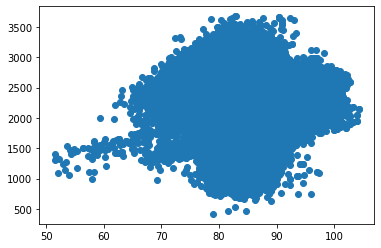

In [23]:
fig,ax = plt.subplots()
ax.scatter(data['release_speed'],data['release_spin_rate'])